In [1]:
import os
import rasterio
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import balanced_accuracy_score, cohen_kappa_score
from sklearn.model_selection import StratifiedKFold

In [5]:
# Set folder and read TIF files
folder = "data_a/sentinel-2"  # Corrected typo in path
tifs = sorted([os.path.join(folder, f) for f in os.listdir(folder) if f.endswith("tif")])
b8, *stack = tifs

In [6]:
b8

'data_a/sentinel-2\\B02.tif'

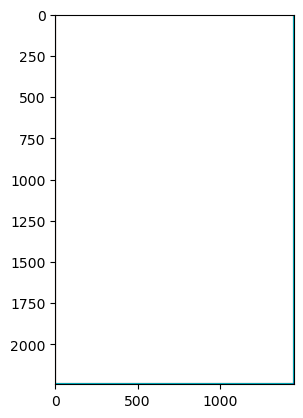

In [35]:
# Read and plot high-resolution raster
with rasterio.open(b8) as src:
    highres = src.read(1)
plt.imshow(highres, cmap='terrain')
plt.show()

In [24]:
def read_bands_sentinel2(directory):
    bands = []
    band_files = ['B02.tif', 'B03.tif', 'B04.tif', 'B05.tif', 'B06.tif', 'B07.tif', 'B08.tif', 'B8A.tif']
    for band_file in band_files:
        file_path = f"{directory}/{band_file}"
        with rasterio.open(file_path) as dataset:
            bands.append(dataset.read(1))
    return bands

# Sentinel-2 bands
sentinel2_bands = read_bands_sentinel2("data_a/sentinel-2")

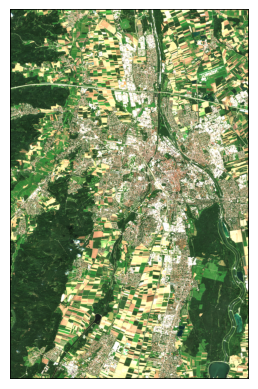

In [25]:
import numpy as np

# Visualization function for Sentinel-2
def visualize_sentinel2(sentinel2_bands, upper_percentile):
    # Standard RGB composite for Sentinel-2: B04 (Red), B03 (Green), B02 (Blue)
    rgb = np.stack([sentinel2_bands[2], sentinel2_bands[1], sentinel2_bands[0]], axis=-1)
    max_val = np.percentile(rgb, upper_percentile * 100)
    rgb_normalized = np.clip(rgb, 0, max_val) / max_val
    plt.imshow(rgb_normalized)
    plt.axis('off')
    plt.show()

visualize_sentinel2(sentinel2_bands, 0.90)

In [26]:
sentinel2_bands[0]

array([[-3.4e+38, -3.4e+38, -3.4e+38, ..., -3.4e+38, -3.4e+38, -3.4e+38],
       [-3.4e+38, -3.4e+38, -3.4e+38, ..., -3.4e+38, -3.4e+38, -3.4e+38],
       [-3.4e+38, -3.4e+38, -3.4e+38, ..., -3.4e+38, -3.4e+38, -3.4e+38],
       ...,
       [-3.4e+38, -3.4e+38, -3.4e+38, ..., -3.4e+38, -3.4e+38, -3.4e+38],
       [-3.4e+38, -3.4e+38, -3.4e+38, ..., -3.4e+38, -3.4e+38, -3.4e+38],
       [-3.4e+38, -3.4e+38, -3.4e+38, ..., -3.4e+38, -3.4e+38, -3.4e+38]],
      dtype=float32)

In [28]:
def safe_divide(numerator, denominator, epsilon=1e-10):
    # Use a safe divide function to handle potential division by zero issues
    return numerator / (denominator + epsilon)

def brightness(sentinel2):
    # Placeholder coefficients for Sentinel-2 brightness index
    b2, b3, b4, b8 = sentinel2[:4]  # Using first four bands as an example
    return b2 * 0.3 + b3 * 0.3 + b4 * 0.3 + b8 * 0.1

def greenness(sentinel2):
    # Placeholder coefficients for Sentinel-2 greenness index
    b2, b3, b4, b8 = sentinel2[:4]  # Using first four bands as an example
    return b3 * 0.5 - b2 * 0.2 - b4 * 0.2 - b8 * 0.1

def wetness(sentinel2):
    # Placeholder coefficients for Sentinel-2 wetness index
    b2, b3, b4, b8 = sentinel2[:4]  # Using first four bands as an example
    return b8 * 0.5 - b3 * 0.2 - b2 * 0.2 - b4 * 0.1

def mndwi(sentinel2):
    green, nir = sentinel2[1].astype(float), sentinel2[6].astype(float)  # Ensure floating-point
    return safe_divide(green - nir, green + nir)

def ndbi(sentinel2):
    red, nir = sentinel2[2].astype(float), sentinel2[6].astype(float)  # Ensure floating-point
    return safe_divide(nir - red, nir + red)

def ndvi(sentinel2):
    nir, red = sentinel2[6].astype(float), sentinel2[2].astype(float)  # Ensure floating-point
    return safe_divide(nir - red, nir + red)

def savi(sentinel2, L=0.5):
    nir, red = sentinel2[6].astype(float), sentinel2[2].astype(float)  # Ensure floating-point
    return ((nir - red) / (nir + red + L)) * (1 + L)


In [29]:
from rasterio.enums import Resampling
import rasterio

def resample_band(band, target_shape):
    # Adjust band data to target shape
    data = band.read(
        out_shape=target_shape,
        resampling=Resampling.bilinear
    )
    return data

# Define the path to your Sentinel-2 bands
folder = "data_a/sentinel-2"
tifs = sorted([os.path.join(folder, f) for f in os.listdir(folder) if f.endswith(".tif")])

# Assuming you want to resample to the shape of the first band
with rasterio.open(tifs[0]) as first_band:
    target_shape = first_band.shape

# Resample all bands
resampled_bands = []
for tif in tifs:
    with rasterio.open(tif) as band:
        resampled_data = resample_band(band, target_shape=target_shape)
        resampled_bands.append(resampled_data)

In [30]:
sentinel2_bands = resampled_bands

In [31]:
# List of functions
functions = [mndwi, ndbi, ndvi, savi, brightness, greenness, wetness]

# Apply each function to the landsat data
# This will create a list of tuples with the function name and its output raster
smrs = [(func.__name__, func(sentinel2_bands)) for func in functions]

# If you need a dictionary instead of a list of tuples:
smrs_dict = {func.__name__: func(sentinel2_bands) for func in functions}

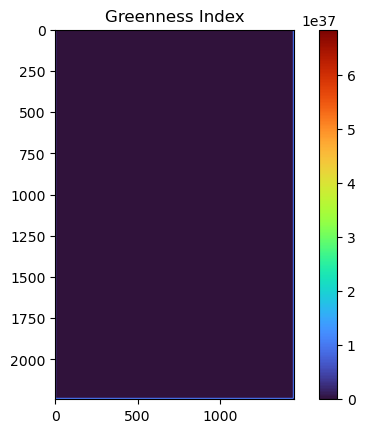

In [34]:
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_laplace

# Find the 'greenness' raster in the list of tuples and plot it
greenness_raster = next(raster for name, raster in smrs if name == 'greenness')

# Reshape the raster to 2D if it's 3D with one channel
if greenness_raster.ndim == 3 and greenness_raster.shape[0] == 1:
    greenness_raster = greenness_raster.squeeze()  # Remove the first dimension

# Now plot the 2D raster data
plt.imshow(greenness_raster, cmap='turbo')
plt.colorbar()  # To add a color bar
plt.title('Greenness Index')
plt.show()

Shape after squeezing: (2242, 1447)
Min value: -2.0282409575317472e+30
Max value: 6.842127888804185e+37


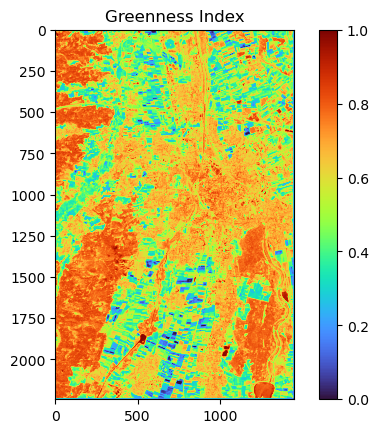

In [37]:
import numpy as np

# Reshape the resampled bands
resampled_bands_2d = [np.squeeze(band) for band in resampled_bands]

# Check the shape again
print("Shape after squeezing:", resampled_bands_2d[0].shape)

# Display the range of values in greenness_raster
print(f"Min value: {greenness_raster.min()}")
print(f"Max value: {greenness_raster.max()}")

# Normalize the data range for better visualization
greenness_raster_normalized = (greenness_raster - greenness_raster.min()) / (greenness_raster.max() - greenness_raster.min())

# Calculate percentiles to remove outliers
lower_percentile = np.percentile(greenness_raster, 2)
upper_percentile = np.percentile(greenness_raster, 98)

# Clip values to the 2nd and 98th percentiles
greenness_raster_clipped = np.clip(greenness_raster, lower_percentile, upper_percentile)

# Normalize the clipped data
greenness_raster_normalized = (
    greenness_raster_clipped - greenness_raster_clipped.min()) / (
    greenness_raster_clipped.max() - greenness_raster_clipped.min())

# Plot the normalized and clipped raster data
plt.imshow(greenness_raster_normalized, cmap='turbo')
plt.colorbar()  # To add a color bar
plt.title('Greenness Index')
plt.show()

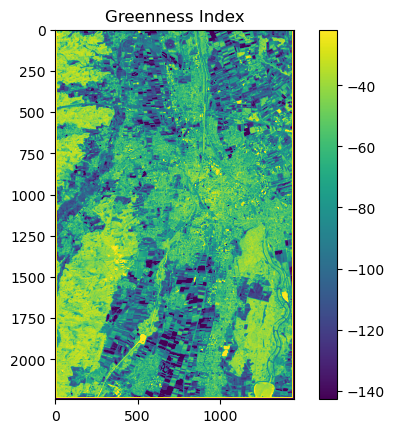

In [38]:
# Squeeze the 'greenness_raster' to ensure it is 2D
greenness_raster_2d = np.squeeze(greenness_raster)

# Now let's recalculate the percentiles on the squeezed array
vmin, vmax = np.percentile(greenness_raster_2d, [5, 95])  # Adjust the percentiles as needed

# Choose a different colormap
cmap = plt.cm.viridis

# Plot the greenness index with the adjusted color scale and colormap
plt.imshow(greenness_raster_2d, cmap=cmap, vmin=vmin, vmax=vmax)
plt.colorbar()
plt.title('Greenness Index')
plt.show()

Before clipping:
Min value: -1.5756709348548058e+37
Max value: 1.2520436663333995e+37
After clipping:
Min value: -5.127068312336834e+36
Max value: 2.830123454241289e+36


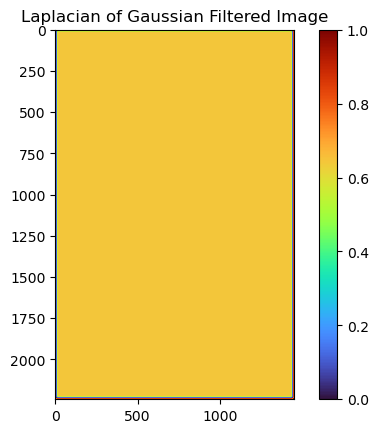

In [55]:
# Apply Laplacian of Gaussian (LoG)
sigma = 3
out2 = gaussian_laplace(highres, sigma=sigma)

# Find the min and max values after applying LoG for debugging
min_value = out2.min()
max_value = out2.max()
print("Before clipping:")
print(f"Min value: {min_value}")
print(f"Max value: {max_value}")

# Calculate percentiles for a more aggressive clipping
lower_percentile = np.percentile(out2, 1)
upper_percentile = np.percentile(out2, 99)

# Clip values more aggressively to the 1st and 99th percentiles
out2_clipped = np.clip(out2, lower_percentile, upper_percentile)

# Find the min and max values after clipping for debugging
min_clipped = out2_clipped.min()
max_clipped = out2_clipped.max()
print("After clipping:")
print(f"Min value: {min_clipped}")
print(f"Max value: {max_clipped}")

# Normalize the clipped data
out2_normalized = (out2_clipped - min_clipped) / (max_clipped - min_clipped)

# Plot the normalized and clipped LoG filtered image
plt.imshow(out2_normalized, cmap='turbo')
plt.colorbar()
plt.title('Laplacian of Gaussian Filtered Image')
plt.show()

In [72]:
import numpy as np
import rasterio
from rasterio.warp import reproject, Resampling

# Define the function to convert digital numbers to reflectance for Sentinel-2
def sentinel_dn_to_reflectance(array, band_number, scale_factor, add_constant):
    # The scale factor and add_constant values should be retrieved from the metadata
    # For the sake of this example, we're using placeholders
    # Sentinel-2's scale factor is generally 0.0001 for reflectance bands
    return array * scale_factor + add_constant

# Read and process Sentinel-2 bands
sentinel2_bands = read_bands_sentinel2("data_a/sentinel-2")

# Convert Sentinel-2 bands to reflectance
# You will need to look up the correct scale factors and add_constants for each band
scale_factors = [0.0001] * len(sentinel2_bands)  # Replace with correct values from metadata
add_constants = [0.0] * len(sentinel2_bands)    # Replace with correct values from metadata

sentinel2_sr = [sentinel_dn_to_reflectance(band, i, scale_factors[i], add_constants[i]) 
                for i, band in enumerate(sentinel2_bands)]

# Replace infinite values with 0.0 for each band
sentinel2_sr = [np.where(np.isinf(band), 0.0, band) for band in sentinel2_sr]

# Assuming `smrs` is a list of tuples with (name, raster) for Sentinel-2
# Replace 'landsat_sr' with 'sentinel2_sr' to create the combined raster stack
crst = sentinel2_sr + [band for name, band in smrs]

# Assuming b8 is the file path to the B08 band which is typically used for high-resolution analysis
with rasterio.open(b8) as src:
    affine = src.transform
    crs = src.crs
    target_transform = src.transform  # Assuming b8 has the transform we want to match
    target_shape = src.shape

In [73]:
crst

[array([[-3.3999998e+34, -3.3999998e+34, -3.3999998e+34, ...,
         -3.3999998e+34, -3.3999998e+34, -3.3999998e+34],
        [-3.3999998e+34, -3.3999998e+34, -3.3999998e+34, ...,
         -3.3999998e+34, -3.3999998e+34, -3.3999998e+34],
        [-3.3999998e+34, -3.3999998e+34, -3.3999998e+34, ...,
         -3.3999998e+34, -3.3999998e+34, -3.3999998e+34],
        ...,
        [-3.3999998e+34, -3.3999998e+34, -3.3999998e+34, ...,
         -3.3999998e+34, -3.3999998e+34, -3.3999998e+34],
        [-3.3999998e+34, -3.3999998e+34, -3.3999998e+34, ...,
         -3.3999998e+34, -3.3999998e+34, -3.3999998e+34],
        [-3.3999998e+34, -3.3999998e+34, -3.3999998e+34, ...,
         -3.3999998e+34, -3.3999998e+34, -3.3999998e+34]], dtype=float32),
 array([[-3.3999998e+34, -3.3999998e+34, -3.3999998e+34, ...,
         -3.3999998e+34, -3.3999998e+34, -3.3999998e+34],
        [-3.3999998e+34, -3.3999998e+34, -3.3999998e+34, ...,
         -3.3999998e+34, -3.3999998e+34, -3.3999998e+34],
        [-

In [46]:
# Function to resample an array to match the target raster
def resample_to_raster(src_array, src_transform, src_crs, target_raster_path):
    with rasterio.open(target_raster_path) as target_raster:
        target_shape = target_raster.shape
        target_transform = target_raster.transform
        target_crs = target_raster.crs

        resampled_array = np.empty(target_shape, dtype=src_array.dtype)
        reproject(
            source=src_array,
            destination=resampled_array,
            src_transform=src_transform,
            src_crs=src_crs,
            dst_transform=target_transform,
            dst_crs=target_crs,
            resampling=Resampling.bilinear
        )
        return resampled_array

# Assuming crst is a list of numpy arrays representing the combined raster stack
# Define paths to training and validation set rasters
train_raster_path = os.path.join("data_a/augsburg_training.tif")
val_raster_path = os.path.join("data_a/augsburg_validation.tif")

In [47]:
# Open the first raster in sentinel2_bands to get crs and transform
with rasterio.open(b8) as src:  # Assuming you want to use B02 for crs and transform
    src_transform = src.transform
    src_crs = src.crs

# Resample your stack to the training and validation datasets
trainrs = [resample_to_raster(raster, src_transform, src_crs, train_raster_path) for raster in crst]
valrs = [resample_to_raster(raster, src_transform, src_crs, val_raster_path) for raster in crst]

In [183]:
valrs

[array([[0.15356918, 0.18619078, 0.21632533, ..., 0.        , 0.        ,
         0.        ],
        [0.15996372, 0.18228472, 0.20241405, ..., 0.        , 0.        ,
         0.        ],
        [0.17756013, 0.18499236, 0.17683913, ..., 0.        , 0.        ,
         0.        ],
        ...,
        [0.16763321, 0.19904838, 0.19861306, ..., 0.        , 0.        ,
         0.        ],
        [0.15188736, 0.16774144, 0.16060217, ..., 0.        , 0.        ,
         0.        ],
        [0.12164528, 0.12859054, 0.12780843, ..., 0.        , 0.        ,
         0.        ]]),
 array([[0.17233257, 0.20223479, 0.23958778, ..., 0.        , 0.        ,
         0.        ],
        [0.18619048, 0.20579693, 0.22255609, ..., 0.        , 0.        ,
         0.        ],
        [0.20616019, 0.21201495, 0.20929842, ..., 0.        , 0.        ,
         0.        ],
        ...,
        [0.18307601, 0.19629549, 0.20731164, ..., 0.        , 0.        ,
         0.        ],
        [0.1

In [48]:
# Write out the resampled data
with rasterio.open(train_raster_path) as src:
    profile = src.profile
    profile.update(dtype=rasterio.float32, count=len(trainrs))
    with rasterio.open('trainbands_sentinel_augsburg.tif', 'w', **profile) as dst:
        for i, array in enumerate(trainrs, start=1):
            dst.write(array.astype(rasterio.float32), i)

with rasterio.open(val_raster_path) as src:
    profile = src.profile
    profile.update(dtype=rasterio.float32, count=len(valrs))
    with rasterio.open('valbands_sentinel_augsburg.tif', 'w', **profile) as dst:
        for i, array in enumerate(valrs, start=1):
            dst.write(array.astype(rasterio.float32), i)

In [49]:
def rasters_to_dataframe(raster_paths, class_raster_path):
    # Read class raster
    with rasterio.open(class_raster_path) as class_raster:
        class_data = class_raster.read(1).flatten()
    
    data = {'class': class_data}
    
    for i, raster_path in enumerate(raster_paths):
        with rasterio.open(raster_path) as raster:
            raster_data = raster.read(1).flatten()
            band_name = f'band_{i+1}'
            data[band_name] = raster_data
    
    df = pd.DataFrame(data)
    return df

# Define paths to training and validation set rasters
train_raster_path = os.path.join("data_a/augsburg_training.tif")
val_raster_path = os.path.join("data_a/augsburg_validation.tif")

In [50]:
# Open the first raster in crst to get crs and transform
with rasterio.open(b8) as src:  # Assuming b8 is a file path to a raster in crst
    src_transform = src.transform
    src_crs = src.crs

# Resample our stack to the training and validation datasets
trainrs = [resample_to_raster(raster, src_transform, src_crs, train_raster_path) for raster in crst]
valrs = [resample_to_raster(raster, src_transform, src_crs, val_raster_path) for raster in crst]

In [51]:
# Transform the RasterStack into a DataFrame
# Here we need to flatten the raster arrays and combine them into a dataframe
# This can be memory intensive and might need optimization for large rasters

# Helper function to flatten and combine rasters into a dataframe
def rasters_to_dataframe(rasters, class_raster_path):
    # Read class raster
    with rasterio.open(class_raster_path) as class_raster:
        class_data = class_raster.read(1).flatten()
    
    data = {'class': class_data}
    for i, raster in enumerate(rasters):
        data[f'band_{i+1}'] = raster.flatten()
    
    df = pd.DataFrame(data)
    return df

# Create dataframes for training and validation
train_df = rasters_to_dataframe(trainrs, train_raster_path)
val_df = rasters_to_dataframe(valrs, val_raster_path)

In [52]:
train_df

class  band_1  band_2  band_3  band_4  band_5  band_6  band_7  \
0          0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
1          0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
2          0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
3          0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
4          0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
...        ...     ...     ...     ...     ...     ...     ...     ...   
3098515    0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
3098516    0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
3098517    0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
3098518    0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
3098519    0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   

         band_8  band_9  band_10  band_11  band_12  band_13  band_14  band_15  
0           0.0     0.0      0.0      0.0      0.0      0.0      0.0      0.0  
1           0.0     0.0      0.0      0.0      0.0      0.0      0.0      0.0  
2           0.0     0.0      0.0      0.0      0.0      0.0      0.0      0.0  
3           0.0     0.0      0.0      0.0      0.0      0.0      0.0      0.0  
4           0.0     0.0      0.0      0.0      0.0      0.0      0.0      0.0  
...         ...     ...      ...      ...      ...      ...      ...      ...  
3098515     0.0     0.0      0.0      0.0      0.0      0.0      0.0      0.0  
3098516     0.0     0.0      0.0      0.0      0.0      0.0      0.0      0.0  
3098517     0.0     0.0      0.0      0.0      0.0      0.0      0.0      0.0  
3098518     0.0     0.0      0.0      0.0      0.0      0.0      0.0      0.0  
3098519     0.0     0.0      0.0      0.0      0.0      0.0      0.0      0.0  

[3098520 rows x 16 columns]

In [75]:
# Combine training and validation dataframes
combined_df = pd.concat([train_df, val_df], ignore_index=True)

# Drop rows where class is 0 and rows with infinite values
#combined_df = combined_df[(combined_df['class'] != 0) & ~np.isinf(combined_df).any(axis=1)]

# Drop 'X' and 'Y' if they exist in the dataframe
combined_df = combined_df.drop(columns=['X', 'Y'], errors='ignore')

combined_df

class  band_1  band_2  band_3  band_4  band_5  band_6  band_7  \
0          0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
1          0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
2          0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
3          0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
4          0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
...        ...     ...     ...     ...     ...     ...     ...     ...   
6563830    0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
6563831    0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
6563832    0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
6563833    0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
6563834    0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   

         band_8  band_9  band_10  band_11  band_12  band_13  band_14  band_15  
0           0.0     0.0      0.0      0.0      0.0      0.0      0.0      0.0  
1           0.0     0.0      0.0      0.0      0.0      0.0      0.0      0.0  
2           0.0     0.0      0.0      0.0      0.0      0.0      0.0      0.0  
3           0.0     0.0      0.0      0.0      0.0      0.0      0.0      0.0  
4           0.0     0.0      0.0      0.0      0.0      0.0      0.0      0.0  
...         ...     ...      ...      ...      ...      ...      ...      ...  
6563830     0.0     0.0      0.0      0.0      0.0      0.0      0.0      0.0  
6563831     0.0     0.0      0.0      0.0      0.0      0.0      0.0      0.0  
6563832     0.0     0.0      0.0      0.0      0.0      0.0      0.0      0.0  
6563833     0.0     0.0      0.0      0.0      0.0      0.0      0.0      0.0  
6563834     0.0     0.0      0.0      0.0      0.0      0.0      0.0      0.0  

[6563835 rows x 16 columns]

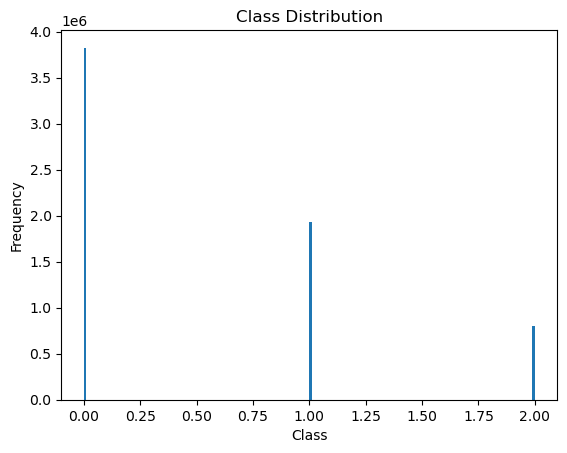

c:\Users\leoni\Programme\Miniconda\envs\geo\Lib\site-packages\numpy\core\_methods.py:49: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
c:\Users\leoni\Programme\Miniconda\envs\geo\Lib\site-packages\pandas\core\nanops.py:1010: RuntimeWarning: overflow encountered in square
  sqr = _ensure_numeric((avg - values) ** 2)
c:\Users\leoni\Programme\Miniconda\envs\geo\Lib\site-packages\numpy\core\_methods.py:49: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
c:\Users\leoni\Programme\Miniconda\envs\geo\Lib\site-packages\pandas\core\nanops.py:1010: RuntimeWarning: overflow encountered in square
  sqr = _ensure_numeric((avg - values) ** 2)
c:\Users\leoni\Programme\Miniconda\envs\geo\Lib\site-packages\numpy\core\_methods.py:49: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
c:\Users\leoni\Programme\Miniconda\e

              class        band_1        band_2        band_3        band_4  \
count  6.563835e+06  6.563835e+06  6.563835e+06  6.563835e+06  6.563835e+06   
mean   5.394864e-01          -inf          -inf          -inf          -inf   
std    7.021756e-01           inf           inf           inf           inf   
min    0.000000e+00 -3.400000e+34 -3.400000e+34 -3.400000e+34 -3.400000e+34   
25%    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
50%    0.000000e+00  2.691006e-02  4.959801e-02  2.929297e-02  8.296931e-02   
75%    1.000000e+00  5.547022e-02  8.088248e-02  7.958776e-02  1.242246e-01   
max    2.000000e+00  1.866486e+00  1.755200e+00  1.676086e+00  1.639886e+00   

             band_5        band_6        band_7        band_8        band_9  \
count  6.563835e+06  6.563835e+06  6.563835e+06  6.563835e+06  6.563835e+06   
mean           -inf          -inf          -inf          -inf -3.038020e-01   
std             inf           inf           inf    

class      float64
band_1     float32
band_2     float32
band_3     float32
band_4     float32
band_5     float32
band_6     float32
band_7     float32
band_8     float32
band_9     float64
band_10    float64
band_11    float64
band_12    float64
band_13    float64
band_14    float64
band_15    float64
dtype: object

In [54]:
from sklearn.preprocessing import LabelEncoder

# Assuming 'combined_df' is your DataFrame and it includes a 'class' column
# Plot a histogram of the 'class' column
plt.hist(combined_df['class'], bins='auto')  # 'auto' lets matplotlib decide the number of bins
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.show()

# Convert the 'class' column to a numerical format if it's categorical
if combined_df['class'].dtype == 'object':
    le = LabelEncoder()
    combined_df['class'] = le.fit_transform(combined_df['class'])

# Describe the DataFrame to check for Inf, NaNs, or other odd patterns
description = combined_df.describe(include='all')  # include='all' to get statistics for all columns
print(description)

# Print out the schema of the DataFra
combined_df.dtypes

In [56]:
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.metrics import balanced_accuracy_score, cohen_kappa_score, make_scorer
from xgboost import XGBClassifier
import numpy as np

# Assuming 'combined_df' is the DataFrame with your data and 'class' is the target column
y = combined_df['class'].values
#y = combined_df['class'].values - 1  # Subtract 1 to make classes start from 0
X = combined_df.drop(columns=['class']).values

# Initialize the XGBoost classifier
tree = XGBClassifier(random_state=123)  # Tree is a reserved keyword in Python, so we use 'tree' variable

# Define the cross-validation strategy
cv_strategy = StratifiedKFold(n_splits=6, shuffle=True, random_state=123)

# Define scoring metrics
scoring_metrics = {
    'balanced_accuracy': make_scorer(balanced_accuracy_score),
    'kappa': make_scorer(cohen_kappa_score)
}

# Evaluate the model using cross-validation
pe = cross_validate(tree, X, y, cv=cv_strategy, scoring=scoring_metrics, verbose=1)

# Print the measurements
print(f"Balanced Accuracy: {np.mean(pe['test_balanced_accuracy'])}")
print(f"Cohen's Kappa: {np.mean(pe['test_kappa'])}")

Balanced Accuracy: 0.7107259583185637
Cohen's Kappa: 0.6409075068378953


In [57]:
# Check the shapes of all rasters in crst
raster_shapes = [raster.shape for raster in crst]
if not all(shape == raster_shapes[0] for shape in raster_shapes):
    print("Not all rasters have the same shape:", raster_shapes)
else:
    print("All rasters have the same shape:", raster_shapes[0])

    # Assuming all rasters are now confirmed to be of the same shape
    dfn = pd.DataFrame({f'band_{i}': raster.flatten() for i, raster in enumerate(crst)})

Not all rasters have the same shape: [(2242, 1447), (2242, 1447), (2242, 1447), (2242, 1447), (2242, 1447), (2242, 1447), (2242, 1447), (2242, 1447), (1, 2242, 1447), (1, 2242, 1447), (1, 2242, 1447), (1, 2242, 1447), (1, 2242, 1447), (1, 2242, 1447), (1, 2242, 1447)]


In [58]:
from rasterio.warp import reproject, calculate_default_transform

def resize_raster_array(array, src_transform, src_crs, target_shape, target_bounds):
    # Calculate the new transform
    new_transform, width, height = calculate_default_transform(
        src_crs, src_crs, target_shape[1], target_shape[0], *target_bounds)
    
    # Set up an empty array for the resampled data
    resampled_array = np.empty((height, width), dtype=array.dtype)

    # Perform the resampling
    reproject(
        source=array,
        destination=resampled_array,
        src_transform=src_transform,
        src_crs=src_crs,
        dst_transform=new_transform,
        dst_crs=src_crs,
        resampling=Resampling.nearest
    )
    
    return resampled_array

# Assuming 'crst' is your list of rasters (numpy arrays)
# and 'b8' is the file path of a raster with the correct size
with rasterio.open(b8) as src:
    target_shape = src.shape
    src_transform = src.transform
    src_crs = src.crs
    target_bounds = src.bounds

# Resize rasters in 'crst' if needed
resized_crst = [resize_raster_array(raster, src_transform, src_crs, target_shape, target_bounds) if raster.shape != target_shape else raster for raster in crst]

# Convert resized_crst to a DataFrame
dfn = pd.DataFrame({f'band_{i}': raster.flatten() for i, raster in enumerate(resized_crst)})

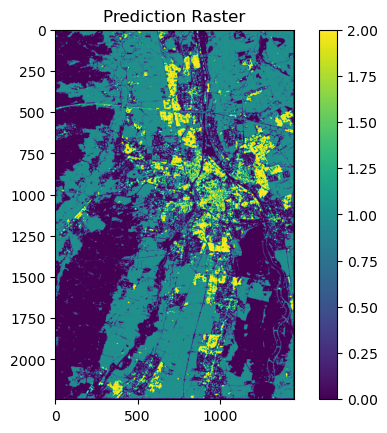

In [59]:
# Assuming 'crst' is a list of rasters (numpy arrays)
# Convert the list of rasters to a DataFrame
#dfn = pd.DataFrame({f'band_{i}': raster.flatten() for i, raster in enumerate(crst)})

# Replace any non-finite values (like Inf) with 0
dfn = dfn.replace([np.inf, -np.inf], 0)

# Train the model
tree.fit(X, y)  # X and y should be your training data and labels

# Now you can make predictions
pred = tree.predict(dfn)

nodata_value = -9999  # You can choose any valid int32 value as the nodata value

# Assuming 'srs' is one of the original rasters and has the same spatial dimensions as 'crst'
with rasterio.open(b8) as src:  # Assuming b8 is a path to one of your rasters
    profile = src.profile
    profile.update(dtype=rasterio.int32, count=1, nodata=nodata_value)

    # Reshape the prediction array to match the spatial dimensions and write to a new raster file
    pred_reshaped = pred.reshape(src.shape).astype(np.int32)
    with rasterio.open('prediction.tif', 'w', **profile) as dst:
        dst.write(pred_reshaped, 1)

plt.imshow(pred_reshaped, cmap='viridis')  # Change colormap as needed
plt.colorbar()
plt.title('Prediction Raster')
plt.show()

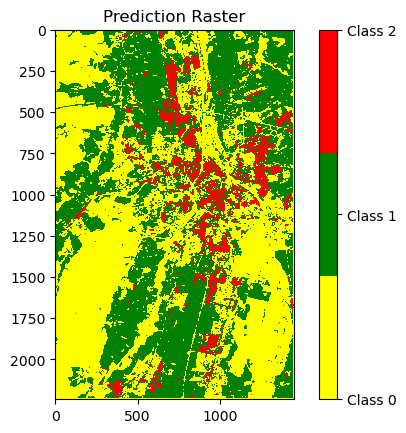

In [60]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# Create a new figure and axis object
fig, ax = plt.subplots()

# Define the colors for each class
class_colors = ['yellow', 'green', 'red']  # Class 0 = yellow, 1 = green, 2 = red

# Create a ListedColormap object based on the class colors
cmap = ListedColormap(class_colors)

# Assuming 'pred_reshaped' is your 2D array of predictions
# Replace any non-finite values (like Inf) with the nodata value
pred_reshaped = np.where(np.isfinite(pred_reshaped), pred_reshaped, nodata_value)

# Mask the nodata values so they are not colored in the plot
masked_predictions = np.ma.masked_where(pred_reshaped == nodata_value, pred_reshaped)

# Plot the masked predictions array with the custom colormap
cbar = ax.imshow(masked_predictions, cmap=cmap)

# Optionally, create a colorbar with labels
colorbar_labels = ['Class 0', 'Class 1', 'Class 2']
cbar = fig.colorbar(cbar, ticks=[0, 1, 2])
cbar.ax.set_yticklabels(colorbar_labels)

# Set the title
ax.set_title('Prediction Raster')

# Display the plot
plt.show()

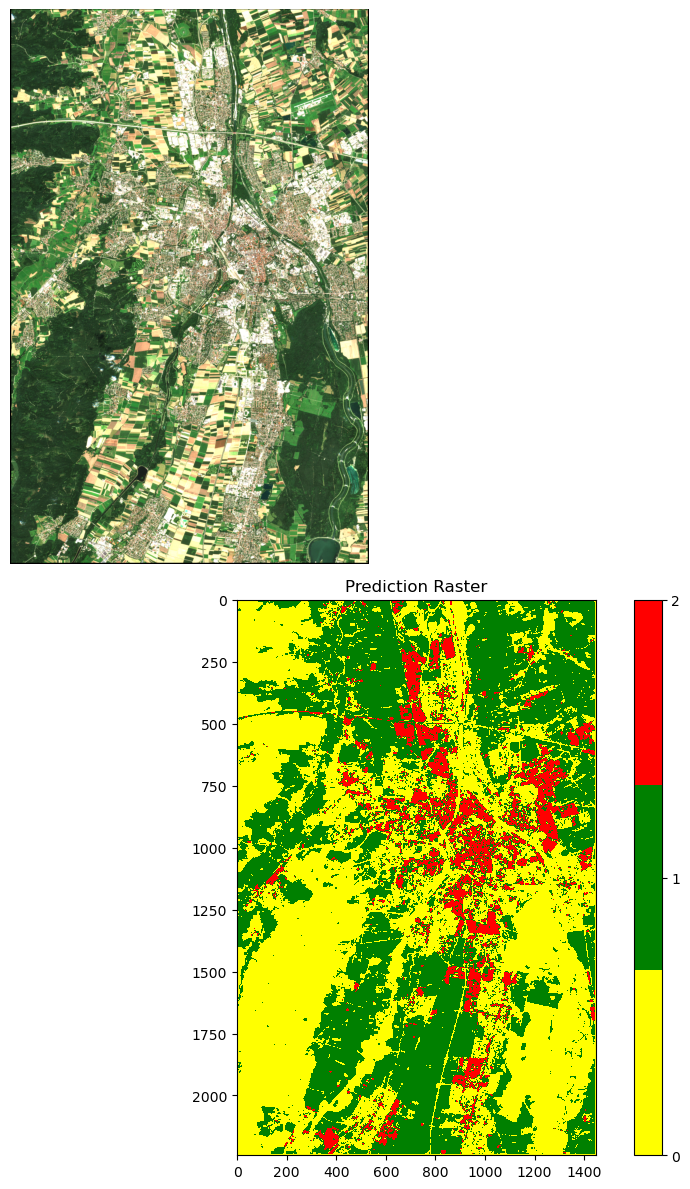

In [61]:
import matplotlib.pyplot as plt

# Your visualization function remains unchanged
def visualize_sentinel2(sentinel2_bands, upper_percentile, ax):
    # Standard RGB composite for Sentinel-2: B04 (Red), B03 (Green), B02 (Blue)
    rgb = np.stack([sentinel2_bands[2], sentinel2_bands[1], sentinel2_bands[0]], axis=-1)
    max_val = np.percentile(rgb, upper_percentile * 100)
    rgb_normalized = np.clip(rgb, 0, max_val) / max_val
    ax.imshow(rgb_normalized)
    ax.axis('off')  # Turn off axis

# Create a figure with two subplots, one above the other
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12))  # Adjust figsize as needed

# Plot the original Sentinel-2 image in the first subplot
visualize_sentinel2(sentinel2_bands, 0.90, ax1)

# Plot the prediction raster in the second subplot
# Assuming 'pred_reshaped' is your 2D numpy array with prediction classes
class_colors = ['yellow', 'green', 'red']  # Class 0 = yellow, 1 = green, 2 = red
cmap = ListedColormap(class_colors)
masked_predictions = np.ma.masked_where(pred_reshaped == nodata_value, pred_reshaped)
cbar = ax2.imshow(masked_predictions, cmap=cmap)
fig.colorbar(cbar, ax=ax2, ticks=[0, 1, 2], fraction=0.036, pad=0.04)  # Adjust colorbar size as needed
ax2.set_title('Prediction Raster')

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

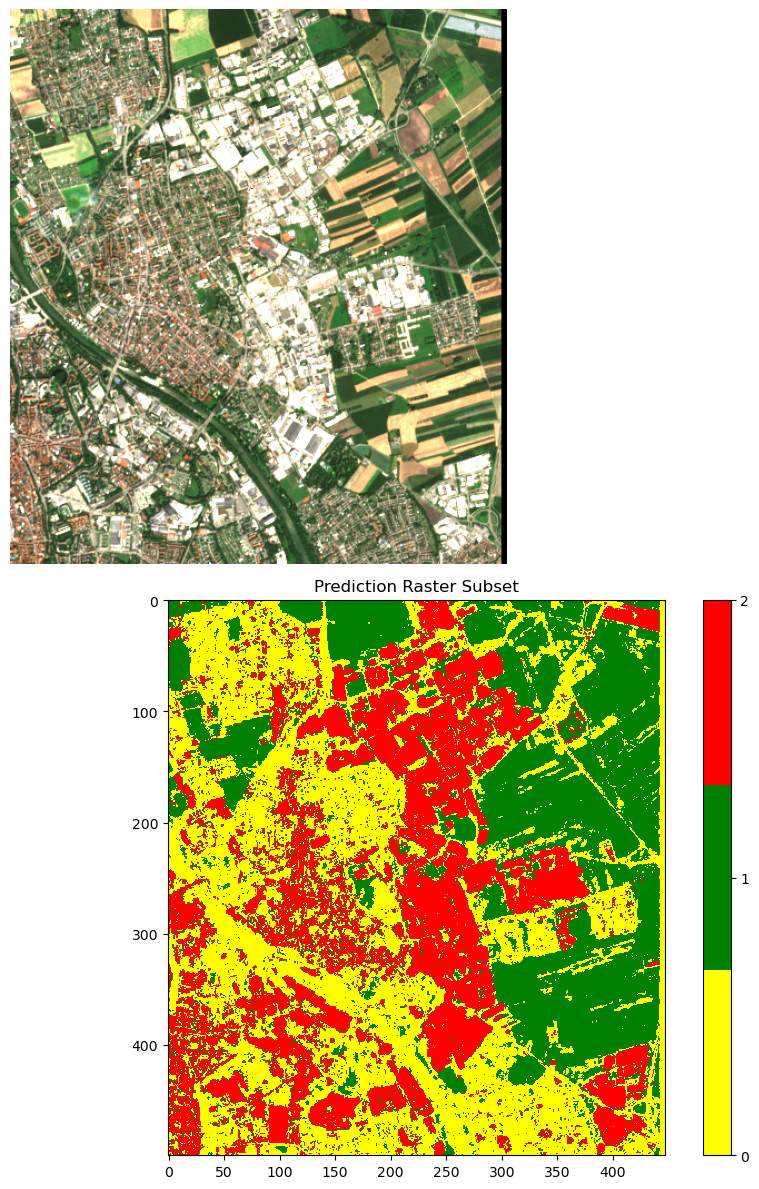

In [78]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# Define the bounds of the subset you want to extract
start_row, start_col = 600, 1000  # for example
end_row, end_col = 1100, 1600     # for example

# Adjust the visualization function to plot a subset
def visualize_sentinel2_subset(sentinel2_bands, upper_percentile, ax, bounds):
    # Standard RGB composite for Sentinel-2: B04 (Red), B03 (Green), B02 (Blue)
    rgb = np.stack([sentinel2_bands[2], sentinel2_bands[1], sentinel2_bands[0]], axis=-1)
    # Crop the RGB composite image
    rgb_subset = rgb[bounds[0]:bounds[2], bounds[1]:bounds[3], :]
    max_val = np.percentile(rgb_subset, upper_percentile * 100)
    rgb_normalized = np.clip(rgb_subset, 0, max_val) / max_val
    ax.imshow(rgb_normalized)
    ax.axis('off')  # Turn off axis

# Create a figure with two subplots, one above the other
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12))  # Adjust figsize as needed

# Plot the subset of the original Sentinel-2 image in the first subplot
visualize_sentinel2_subset(sentinel2_bands, 0.90, ax1, (start_row, start_col, end_row, end_col))

# Plot the subset of the prediction raster in the second subplot
class_colors = ['yellow', 'green', 'red']  # Class 0 = yellow, 1 = green, 2 = red
cmap = ListedColormap(class_colors)

# Crop the prediction raster to the same subset bounds
pred_subset = pred_reshaped[start_row:end_row, start_col:end_col]

masked_predictions = np.ma.masked_where(pred_subset == nodata_value, pred_subset)
cbar = ax2.imshow(masked_predictions, cmap=cmap)
fig.colorbar(cbar, ax=ax2, ticks=[0, 1, 2], fraction=0.036, pad=0.04)  # Adjust colorbar size as needed
ax2.set_title('Prediction Raster Subset')

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

In [84]:
from skimage.morphology import opening, disk
from matplotlib.colors import ListedColormap

# Define the structuring element (disk with radius 21)
se_disk = disk(10)

# Apply morphological opening to the prediction raster
pred_opened = opening(pred_reshaped, se_disk)

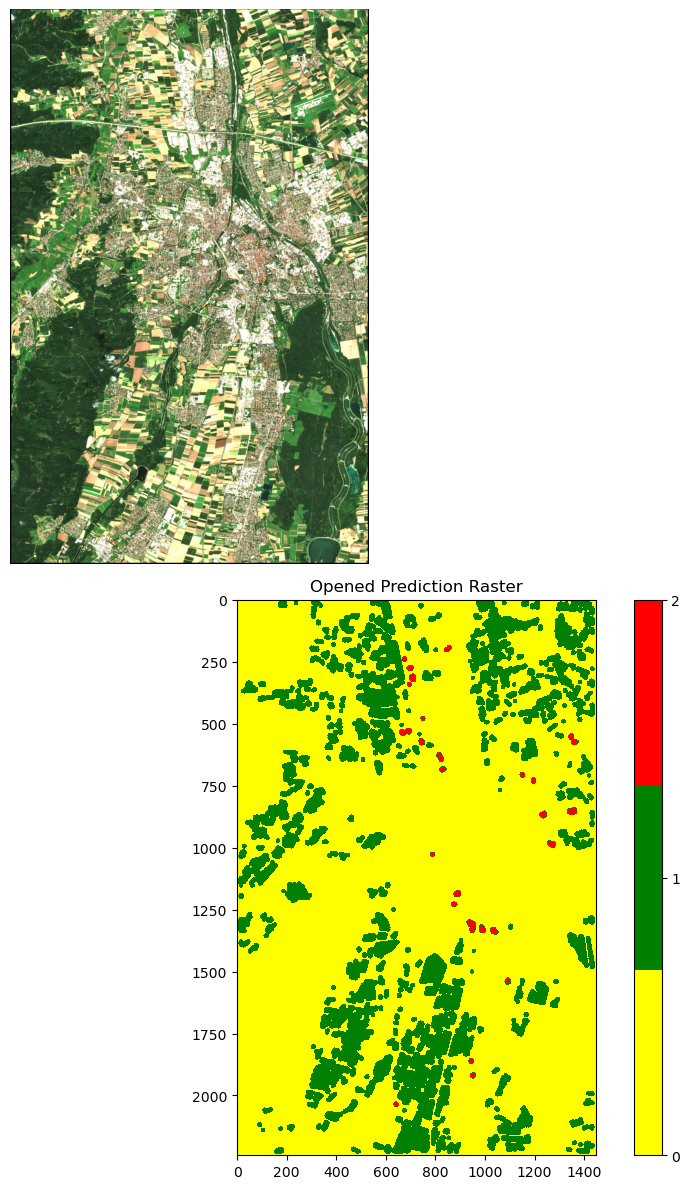

In [88]:
# Your visualization function remains unchanged
def visualize_sentinel2(sentinel2_bands, upper_percentile, ax):
    # Standard RGB composite for Sentinel-2: B04 (Red), B03 (Green), B02 (Blue)
    rgb = np.stack([sentinel2_bands[2], sentinel2_bands[1], sentinel2_bands[0]], axis=-1)
    max_val = np.percentile(rgb, upper_percentile * 100)
    rgb_normalized = np.clip(rgb, 0, max_val) / max_val
    ax.imshow(rgb_normalized)
    ax.axis('off')  # Turn off axis

# Create a figure with two subplots, one above the other
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12))  # Adjust figsize as needed

# Plot the original Sentinel-2 image in the first subplot
visualize_sentinel2(sentinel2_bands, 0.90, ax1)

# Plot the prediction raster after morphological opening in the second subplot
class_colors = ['yellow', 'green', 'red']  # Example colors for classes
cmap = ListedColormap(class_colors)
masked_predictions_opened = np.ma.masked_where(pred_opened == nodata_value, pred_opened)
cbar = ax2.imshow(masked_predictions_opened, cmap=cmap)
fig.colorbar(cbar, ax=ax2, ticks=[0, 1, 2], fraction=0.036, pad=0.04)  # Adjust colorbar size as needed
ax2.set_title('Opened Prediction Raster')

# Adjust layout to prevent overlap and display the plot
plt.tight_layout()
plt.show()

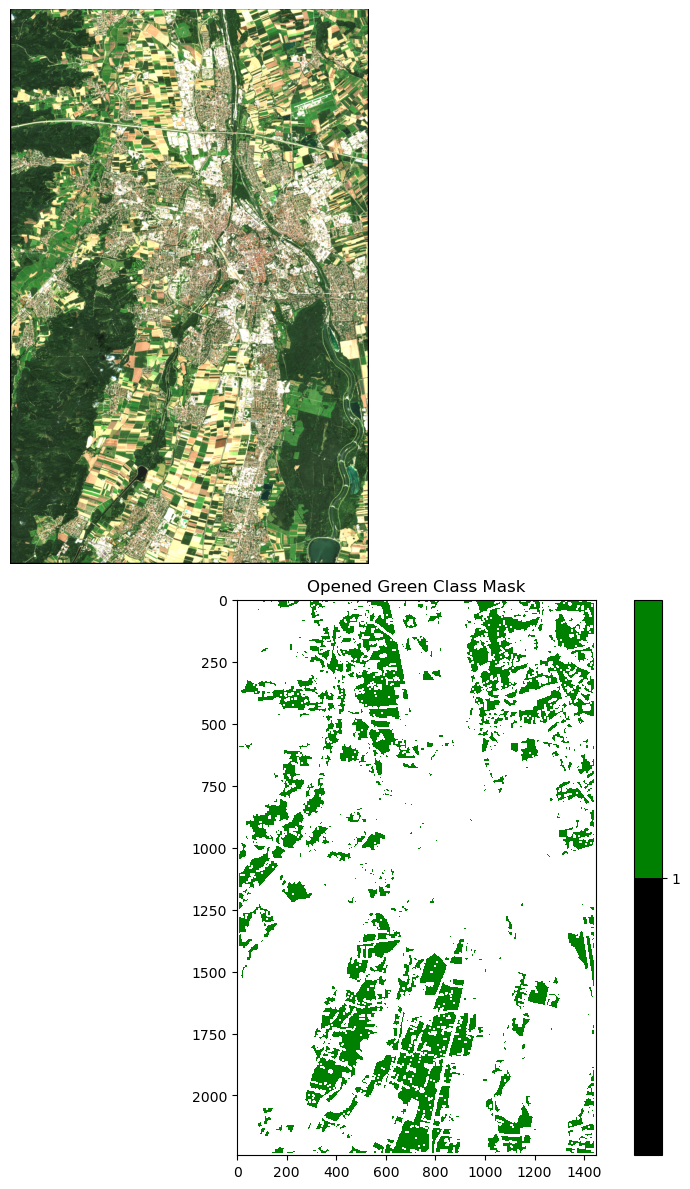

In [113]:
from skimage.morphology import opening, disk
from matplotlib.colors import ListedColormap

# Define the structuring element (disk with radius 21)
se_disk = disk(0)

# Isolate the green class - assuming it's represented by the value 1
green_class = np.where(pred_reshaped == 1, 1, 0)

# Apply morphological opening to the green class only
opened_green_class = opening(green_class, se_disk)

# Combine the opened green class back with the other classes
# We first create a copy of the original prediction to preserve the other class values
pred_combined = pred_reshaped.copy()
# Update the green class in the combined prediction with the processed green class
pred_combined[opened_green_class == 1] = 1

# Now plot the combined prediction raster with the processed green class
# Your visualization function remains unchanged
def visualize_sentinel2(sentinel2_bands, upper_percentile, ax):
    # Standard RGB composite for Sentinel-2: B04 (Red), B03 (Green), B02 (Blue)
    rgb = np.stack([sentinel2_bands[2], sentinel2_bands[1], sentinel2_bands[0]], axis=-1)
    max_val = np.percentile(rgb, upper_percentile * 100)
    rgb_normalized = np.clip(rgb, 0, max_val) / max_val
    ax.imshow(rgb_normalized)
    ax.axis('off')  # Turn off axis

# Create a figure with two subplots, one above the other
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12))  # Adjust figsize as needed

# Plot the original Sentinel-2 image in the first subplot
visualize_sentinel2(sentinel2_bands, 0.90, ax1)

# Plot the opened green class mask in the second subplot
cmap_green = ListedColormap(['black', 'green'])  # Black for background, green for the class
masked_opened_green_class = np.ma.masked_where(opened_green_class == 0, opened_green_class)
cbar = ax2.imshow(masked_opened_green_class, cmap=cmap_green)
fig.colorbar(cbar, ax=ax2, ticks=[0, 1], fraction=0.036, pad=0.04)  # Adjust colorbar size as needed
ax2.set_title('Opened Green Class Mask')

# Adjust layout to prevent overlap and display the plot
plt.tight_layout()
plt.show()

In [108]:
opened_green_class

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [109]:
import rasterio
from rasterio.transform import from_origin

# Assuming 'opened_green_class' is your green mask after applying the morphological operation
# and 'pred_reshaped' is the original prediction raster with spatial dimensions

# Open one of the original rasters to use as a template for the profile
with rasterio.open(b8) as src:
    # Copy the metadata
    out_meta = src.meta.copy()

# Define the nodata value within the uint8 range
nodata_value_uint8 = 255

# Ensure 'opened_green_class' is a regular numpy array with the correct data type
opened_green_class_uint8 = opened_green_class.astype('uint8')

# Update the metadata to use the new nodata value and ensure the data type is uint8
out_meta.update({
    "count": 1,
    "dtype": 'uint8',
    "nodata": nodata_value_uint8
})

# Write the green mask to a new TIFF file
with rasterio.open('green_mask2.tif', 'w', **out_meta) as dest:
    # Write the green mask band, using the data directly
    dest.write(opened_green_class_uint8, 1)

print("Green mask saved to 'green_mask2.tif'")

Green mask saved to 'green_mask2.tif'


In [110]:
from samgeo import tms_to_geotiff
from samgeo import SamGeo

sam = SamGeo(
    model_type="vit_h",
    automatic=False,
    sam_kwargs=None,
)

sam.raster_to_vector("green_mask2.tif", "data/green_mask2.shp")